In [1]:
path = "outputs/"
math = "math_rewards.json"
rhyme = "poem_just_rhyme_rewards.json"
poem_varied = "poem_varied_unique_words_and_rhyme.json"
from genericpath import exists
import json
with open(path + math, 'r') as f:
    math_rewards = json.load(f)
with open(path + rhyme, 'r') as f:
    rhyme_rewards = json.load(f)
with open(path + poem_varied, 'r') as f:
    poem_varied_rewards = json.load(f)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
def average_reward_per_step(step: list):
    length = len(step)
    if length == 0:
        return 0
    total_reward = sum(step)
    return total_reward / length
def compute_averages(rewards: list):
    averages = []
    for i in rewards:
        averages.append(average_reward_per_step(i))
    return averages
def find_first_plateau(averages, window=10, tol=1e-3, method='final_mean'):
    """
    Find the first episode (1-based) where the series enters a plateau.

    - `window` : number of consecutive points required to consider it 'stable'.
    - `tol`    : absolute tolerance from the plateau value.
    - `method` : 'final_mean' (default) uses mean of last `window` points as plateau value,
                 'global_max' uses global maximum as plateau value.
    Returns: 1-based index (int). If none found, returns the first occurrence of the global max.
    """
    arr = np.asarray(averages, dtype=float)
    n = arr.size
    if n == 0:
        return None

    if method == 'final_mean':
        w = min(window, n)
        plateau_value = arr[-w:].mean()
    elif method == 'global_max':
        plateau_value = arr.max()
    else:
        plateau_value = arr.max()

    run_len = min(window, n)
    # require at least 2 points for a regression later
    run_len = max(2, run_len)

    for i in range(0, n - (run_len - 1)):
        segment = arr[i:i + run_len]
        if np.all(np.abs(segment - plateau_value) <= tol):
            return int(i + 1)  # convert to 1-based episode number

    # fallback: return first index of global max (1-based)
    return int(np.argmax(arr) + 1)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def _format_linear_eq(z):
    slope, intercept = float(z[0]), float(z[1])
    return f"y = {slope:.4f}x + {intercept:.4f}"

def _format_log_eq(z):
    a, b = float(z[0]), float(z[1])
    return f"y = {a:.4f} log(x) + {b:.4f}"

def _format_exp_eq(coeffs):
    a, b = float(coeffs[0]), float(coeffs[1])
    return f"y = {a:.4e} * exp({b:.4e} x)"

def _format_sat_eq(coeffs):
    L, A, k = float(coeffs[0]), float(coeffs[1]), float(coeffs[2])
    return f"y = {L:.4f} - {A:.4f} exp(-{k:.4e} x)"


def find_first_plateau(averages, window=10, tol=1e-3, method='final_mean'):
    arr = np.asarray(averages, dtype=float)
    n = arr.size
    if n == 0:
        return None
    if method == 'final_mean':
        w = min(window, n)
        plateau_value = arr[-w:].mean()
    else:
        plateau_value = arr.max()
    run_len = max(2, min(window, n))
    for i in range(0, n - (run_len - 1)):
        segment = arr[i:i+run_len]
        if np.all(np.abs(segment - plateau_value) <= tol):
            return int(i + 1)   # 1-based episode index
    return int(np.argmax(arr) + 1)

def plot_averages(data, title="Averages", show_linear=False, show_log=False,
                  show_peak=False, show_exp=False, show_sat=False, plateau_kwargs=None):
    """
    Plots averages and returns regression/peak info.
    Extended to optionally fit exponential (show_exp) and saturating exponential (show_sat).
    Returns dict with keys: 'linear','log','peak','exp','sat'.
    """
    # ...existing code...
    # compute averages if `data` is raw rewards; if caller already passed averages, accept that too
    try:
        averages = compute_averages(data)
    except Exception:
        averages = data

    averages = np.asarray(averages, dtype=float).ravel()
    if averages.size == 0:
        raise ValueError("No averages to plot")
    if not np.isfinite(averages).all():
        raise ValueError("Averages contain non-finite values")

    steps = np.arange(1, len(averages) + 1)
    plt.plot(steps, averages, label="Average per step", color="C0")
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Average Reward per Step")

    results = {'linear': None, 'log': None, 'peak': None, 'exp': None, 'sat': None}

    if show_linear and averages.size >= 2:
        # ensure 1D numeric arrays
        x = steps.astype(float).ravel()
        y = averages.ravel()
        z = np.polyfit(x, y, 1).ravel()   # [slope, intercept]
        p = np.poly1d(z)
        lin_eq = _format_linear_eq(z)
        plt.plot(x, p(x), "r--", label=f"Linear fit: {lin_eq}")
        results['linear'] = {'coeffs': [float(z[0]), float(z[1])], 'equation': lin_eq}

    if show_log and averages.size >= 2:
        x_log = np.log(steps.astype(float)).ravel()
        y = averages.ravel()
        # if any x_log are -inf (shouldn't be here since steps start at 1), guard
        if np.isfinite(x_log).all():
            z_log = np.polyfit(x_log, y, 1).ravel()  # [a, b] for a*log(x)+b
            p_log = np.poly1d(z_log)
            log_eq = _format_log_eq(z_log)
            plt.plot(steps, p_log(x_log), "g--", label=f"Log fit: {log_eq}")
            results['log'] = {'coeffs': [float(z_log[0]), float(z_log[1])], 'equation': log_eq}

    if show_peak:
        kwargs = plateau_kwargs or {}
        peak_episode = find_first_plateau(averages, **kwargs)
        if peak_episode is not None:
            peak_idx = int(peak_episode)
            # convert peak_idx (1-based) to slice length; ensure at least 2 points for fit
            if peak_idx >= 2:
                peak_steps = steps[:peak_idx].astype(float).ravel()
                peak_avgs = averages[:peak_idx].ravel()
                if peak_steps.size >= 2:
                    z_peak = np.polyfit(peak_steps, peak_avgs, 1).ravel()
                    p_peak = np.poly1d(z_peak)
                    peak_eq = _format_linear_eq(z_peak)
                    plt.plot(peak_steps, p_peak(peak_steps), "m--",
                             label=f"Reg to peak (to ep {peak_idx}): {peak_eq}")
                    results['peak'] = {
                        'coeffs': [float(z_peak[0]), float(z_peak[1])],
                        'equation': peak_eq,
                        'peak_episode': peak_idx
                    }
                else:
                    # not enough points to fit
                    results['peak'] = {'coeffs': None, 'equation': None, 'peak_episode': peak_idx}
            else:
                results['peak'] = {'coeffs': None, 'equation': None, 'peak_episode': peak_idx}

        # Exponential fit: a * exp(b*x)
    if show_exp and averages.size >= 3:
        x = steps.astype(float)
        y = averages.astype(float)
        exp_fit = None
        # prefer curve_fit if available
        if curve_fit is not None and np.all(y > 0):
            def exp_model(x, a, b):
                return a * np.exp(b * x)
            try:
                p0 = (y[0] if y[0] > 0 else 1.0, 0.0)
                popt, _ = curve_fit(exp_model, x, y, p0=p0, maxfev=10000)
                exp_fit = popt
                plt.plot(x, exp_model(x, *popt), color="C2", linestyle="--",
                         label=f"Exp fit: {_format_exp_eq(popt)}")
                results['exp'] = {'coeffs': [float(popt[0]), float(popt[1])],
                                  'equation': _format_exp_eq(popt)}
            except Exception:
                exp_fit = None
        # fallback: log-linear (fit log(y) = b*x + log(a))
        if exp_fit is None and np.all(y > 0):
            try:
                b, loga = np.polyfit(x, np.log(y), 1)
                a = np.exp(loga)
                popt = [a, b]
                def exp_model_approx(xv): return a * np.exp(b * xv)
                plt.plot(x, exp_model_approx(x), color="C2", linestyle="--",
                         label=f"Exp fit (log-approx): {_format_exp_eq(popt)}")
                results['exp'] = {'coeffs': [float(a), float(b)], 'equation': _format_exp_eq(popt)}
            except Exception:
                pass

    # Saturating exponential: L - A * exp(-k*x)
    if show_sat and averages.size >= 4:
        x = steps.astype(float)
        y = averages.astype(float)
        if curve_fit is not None:
            def sat_model(x, L, A, k):
                return L - A * np.exp(-k * x)
            try:
                p0 = (np.max(y), np.max(y) - np.min(y), 0.01)
                popt, _ = curve_fit(sat_model, x, y, p0=p0, maxfev=20000, bounds=( -np.inf, np.inf))
                plt.plot(x, sat_model(x, *popt), color="C3", linestyle="--",
                         label=f"Sat-exp fit: {_format_sat_eq(popt)}")
                results['sat'] = {'coeffs': [float(popt[0]), float(popt[1]), float(popt[2])],
                                  'equation': _format_sat_eq(popt)}
            except Exception:
                pass

    plt.legend()
    plt.show()

    return results

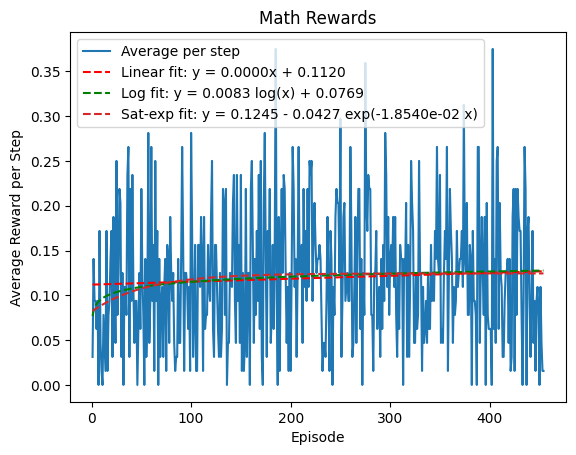

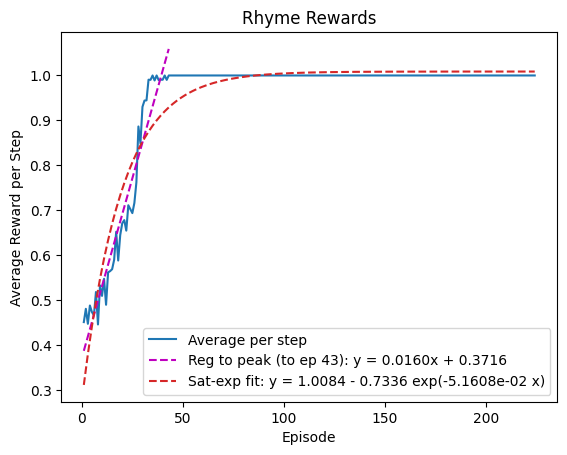

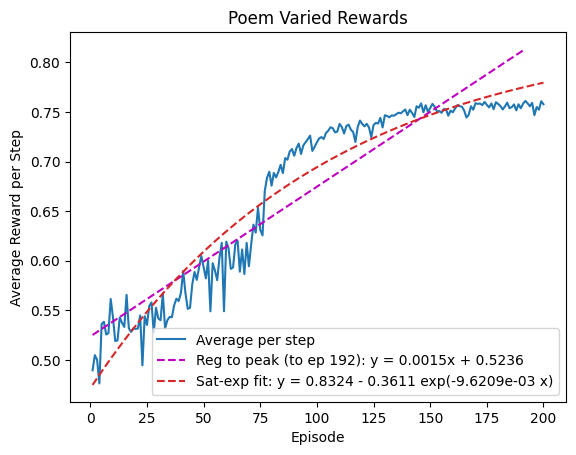

In [8]:
math_eqs = plot_averages(math_rewards, "Math Rewards", show_linear=True, show_log=True, show_exp=False, show_sat=True)
rhyme_eqs = plot_averages(rhyme_rewards, "Rhyme Rewards", show_peak=True, show_exp=False, show_sat=True)
poem_eqs = plot_averages(poem_varied_rewards, "Poem Varied Rewards", show_peak=True, show_exp=False, show_sat=True)

In [14]:
import numpy as np

# assumes math_eqs, rhyme_eqs, poem_eqs, rhyme_rewards, poem_varied_rewards,
# compute_averages and find_first_plateau are available in the notebook

# extract math fits
math_lin = math_eqs.get('linear', {}).get('coeffs')
math_log = math_eqs.get('log', {}).get('coeffs')

# compute target peak values for rhyme and poem
rhyme_avgs = np.asarray(compute_averages(rhyme_rewards), dtype=float).ravel()
rhyme_pk = int(find_first_plateau(rhyme_avgs))
rhyme_val = float(rhyme_avgs[rhyme_pk - 1])

poem_avgs = np.asarray(compute_averages(poem_varied_rewards), dtype=float).ravel()
poem_pk = int(find_first_plateau(poem_avgs))
poem_val = float(poem_avgs[poem_pk - 1])

# predict math episodes to reach those target values using math linear and math log fits
def safe_pred_linear(coeffs, target):
    m, c = float(coeffs[0]), float(coeffs[1])
    if np.isclose(m, 0): return None
    x = (target - c) / m
    return int(np.ceil(x)) if np.isfinite(x) and x >= 1 else None

rhyme_pred_lin = safe_pred_linear(math_lin, rhyme_val) if math_lin is not None else None

poem_pred_lin = safe_pred_linear(math_lin, poem_val) if math_lin is not None else None

print(f"Rhyme peak value={rhyme_val:.6f} (ep {rhyme_pk}): math linear -> {rhyme_pred_lin}")
print(f"Poem  peak value={poem_val:.6f} (ep {poem_pk}): math linear -> {poem_pred_lin}")

# compute linear-vs-linear intersections (math vs rhyme, math vs poem) when both linear fits exist
def intersect(a, b):
    m1, c1 = float(a[0]), float(a[1])
    m2, c2 = float(b[0]), float(b[1])
    if np.isclose(m1, m2): return None
    x = (c2 - c1) / (m1 - m2)
    y = m1 * x + c1
    return {'x': float(x), 'y': float(y)}

if math_lin is not None and rhyme_eqs.get('linear'):
    print("math vs rhyme linear intersection:", intersect(math_lin, rhyme_eqs['linear']['coeffs']))
if math_lin is not None and poem_eqs.get('linear'):
    print("math vs poem  linear intersection:", intersect(math_lin, poem_eqs['linear']['coeffs']))

Rhyme peak value=0.999677 (ep 43): math linear -> 27023
Poem  peak value=0.761220 (ep 192): math linear -> 19765
